In [1]:
from nt_toolbox.general import *
from nt_toolbox.signal import *
import numpy as np
import random as r
import pypher
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import convolve2d as conv2
from scipy.signal import fftconvolve, convolve
from skimage import io,color, data, restoration
from pylab import array
from pypher.pypher import psf2otf
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


C:\Users\trant\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['convolve', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Deblur

### Original image

C:\Users\trant\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\trant\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Text(0.5, 1.0, 'Original')

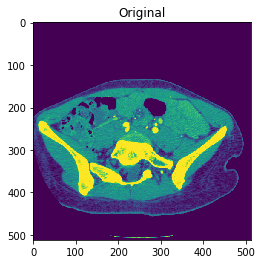

In [2]:
# Load the data...
#image = 'nt_toolbox/data/planet.jpg'
#image = 'nt_toolbox/data/cortex.bmp'
image = 'nt_toolbox/data/Anonymized20190304.jpg'
#image='nt_toolbox/data/pluto.jpg'
im=load_image(image,512)
im=color.rgb2gray(im)
im_arr = np.array(im, dtype=float)
data=im_arr/max(im_arr.reshape(im_arr.shape[0]*im_arr.shape[0],1))
plt.imshow(data)
plt.title('Original')

### Blurred and noisy image

We make convolutions of original image with some kernel, then add Gaussian and Poisson noise.

1.644150190255906e+277
[[0.27363195 0.24242263 0.19027031 ... 0.         0.         0.        ]
 [0.24242263 0.22147963 0.18444224 ... 0.         0.         0.        ]
 [0.19027031 0.18444224 0.17065509 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.17065509 0.18444224 0.19027031]
 [0.         0.         0.         ... 0.18444224 0.22147963 0.24242263]
 [0.         0.         0.         ... 0.19027031 0.24242263 0.27363195]]


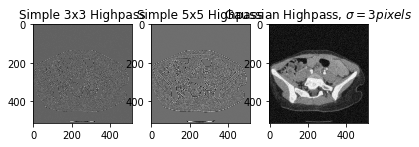

In [3]:
def plot(data, title):
    plot.i += 1
    plt.subplot(1,3,plot.i)
    plt.imshow(data)
    plt.gray()
    plt.title(title)
plot.i = 0
kernel='nt_toolbox/data/irac4.5_to_pacs70.png'
kernel=load_image(kernel,5)
kernel=color.rgb2gray(kernel)
kernel = np.array(kernel*100, dtype=float)
#plot(kernel, 'Original')
# A very simple and very narrow highpass filter
kernel_highpass3x3= np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
#kernel_highpass3x3=kernel
highpass_3x3 = ndimage.convolve(data, kernel_highpass3x3)+(np.random.normal(25, 5,size=data.shape))/255+(np.random.poisson(5,size=data.shape))/255
matrixPSF=ndimage.convolve(np.identity(data.shape[0]),kernel_highpass3x3)
print(det(matrixPSF))
plot(highpass_3x3, 'Simple 3x3 Highpass')

# A slightly "wider", but sill very simple highpass filter 
kernel_highpass5x5 = np.array([[-1, -1, -1, -1, -1],
                   [-1,  1,  2,  1, -1],
                   [-1,  2,  4,  2, -1],
                   [-1,  1,  2,  1, -1],
                   [-1, -1, -1, -1, -1]])
highpass_5x5 = ndimage.convolve(data, kernel_highpass5x5)+(np.random.normal(25, 5,size=data.shape))/255+(np.random.poisson(5,size=data.shape))/255
plot(highpass_5x5, 'Simple 5x5 Highpass')
# Another way of making a highpass filter is to simply subtract a lowpass
# filtered image from the original. Here, we'll use a simple gaussian filter
# to "blur" (i.e. a lowpass filter) the original.
lowpass = ndimage.gaussian_filter(data, 3)
gauss_highpass = data - lowpass
def gkern(l,sig):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))

    return kernel / np.sum(kernel)
kernel_Gaussian=gkern(15,2.)
matrixPSF=ndimage.convolve(np.identity(data.shape[0]),kernel_Gaussian)
print(matrixPSF)
gauss=ndimage.convolve(data, kernel_Gaussian)+(np.random.normal(25, 5,size=data.shape))/255+(np.random.poisson(5,size=data.shape))/255
plot(gauss, r'Gaussian Highpass, $\sigma = 3 pixels$')

plt.show()

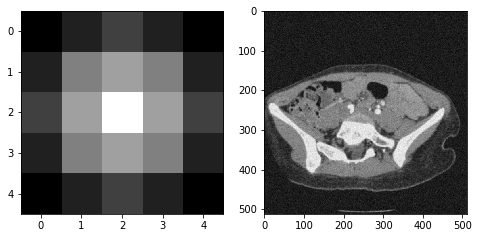

In [4]:
kernel_HST=np.array([[0.00, 0.01, 0.02, 0.01, 0.00],
                     [0.01, 0.04, 0.05, 0.04, 0.01],
                     [0.02, 0.05, 0.08, 0.05, 0.02],
                     [0.01, 0.04, 0.05, 0.04, 0.01],
                     [0.00, 0.01, 0.02, 0.01, 0.00]])
HST= ndimage.convolve(data, kernel_HST)+(np.random.normal(25, 5,size=data.shape))/255+(np.random.poisson(5,size=data.shape))/255
f, axes = plt.subplots(1,2, figsize=(8,5))
axes[1].imshow(HST)
axes[0].imshow(kernel_HST)
plt.show()

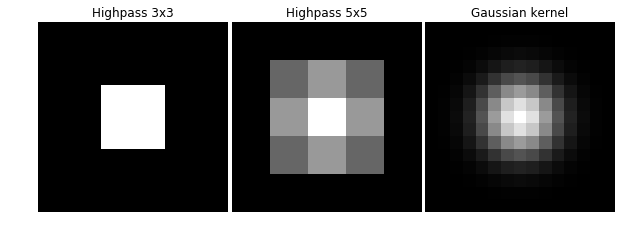

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(kernel_highpass3x3)
ax[0].set_title('Highpass 3x3')

ax[1].imshow(kernel_highpass5x5)
ax[1].set_title('Highpass 5x5')

ax[2].imshow(kernel_Gaussian)
ax[2].set_title('Gaussian kernel')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

### Image reconstruction using original Poisson MLE
We reconstruct blurred and noisy image using the Poisson maximum likelihood estimation:
$$
\min_{x}\sum_{i=1}^m \left\lbrace(Ax)_i+\gamma -f_i\log ((Ax)_i+\gamma)\right\rbrace\quad \text{with } \gamma=\lambda+\sigma^2>0.
$$

Using EM algorithm, we obtain the following iterations:
$$x^{k+1}_j=\dfrac{x^k_j}{\sum_{i=1}^ma_{ij}}\sum_{i=1}^m\dfrac{a_{ij}f_i}{(Ax^k)_i+\gamma}.$$

In [6]:
from scipy.signal import fftconvolve, convolve

def EM(image, psf, maxIter, clip=True):

    Re_img = np.zeros(image.shape)

    psf_mirror = psf[::-1, ::-1]


    for i in range(maxIter):

        relative_blur = image / (ndimage.convolve(Re_img, psf)+30/255*np.ones(image.shape))

        Re_img *= ndimage.convolve(relative_blur, psf_mirror)

    return Re_img

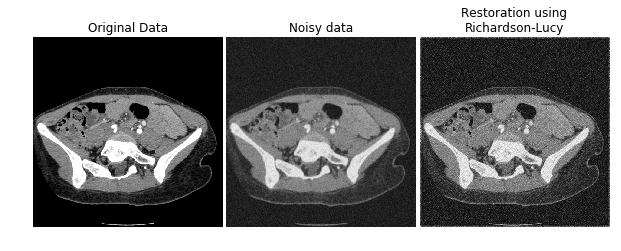

In [7]:
psf = np.array([[0.00, 0.01, 0.02, 0.01, 0.00],
                     [0.01, 0.04, 0.05, 0.04, 0.01],
                     [0.02, 0.05, 0.08, 0.05, 0.02],
                     [0.01, 0.04, 0.05, 0.04, 0.01],
                     [0.00, 0.01, 0.02, 0.01, 0.00]])
blur_img = ndimage.convolve(data, psf)
img_noisy =blur_img.copy()
img_noisy += (np.random.normal(5, np.sqrt(5),size=blur_img.shape))/255+(np.random.poisson(25,size=blur_img.shape))/255

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(img_noisy, psf)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(data)
ax[0].set_title('Original Data')

ax[1].imshow(img_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=img_noisy.min(), vmax=img_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')
#ax[3].imshow(EM_restoration)
#ax[3].set_title('Restoration using PMLE')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

### Image reconstruction using TV-regularized Poisson MLE model
We consider the problem:
$$
\min_x \sum_{i=1}^m \left\lbrace(Ax)_i+\gamma -f_i\log ((Ax)_i+\gamma)\right\rbrace+\alpha\|x\|_{TV},
$$

The ADMM algorithm solving the above problem is:
$\bullet$ Initialize: Take $y^0=w^0=0$, $x^0=z^0=u^0=0$, and $\lambda,\rho_1, \rho_2\in (0,1)$,
			
$\bullet$ Step $i$:
	
   + $x^{k+1}\leftarrow \left(A^TA+\dfrac{\rho_2}{\rho_1}D^TD+\lambda I\right)^{-1}\left( A^Tz^k+\dfrac{A^Tu^k}{\rho_1}+\dfrac{\rho_2}{\rho_1}D^Ty^k+\dfrac{D^Tw^k}{\rho_1}+\lambda x^k\right)$.

   + $z_i^{k+1}\leftarrow \dfrac{-b_i+\sqrt{b_i^2-4a_ic_i}}{2a_i}, \text{ for any } i\in\{1,\ldots,m\}$, where 
    
 $$a_i= \rho_1,$$
      
 $$b_i= 1-\rho_1(Ax^{k+1})_i+u^k_i+\rho_1\gamma,$$
      
 $$c_i=\gamma-f_i-\rho_1\gamma(Ax^{k+1})_i+\gamma u^k_i.$$
    
   
   + $y^{k+1}_i\leftarrow\max\left(\left|\left(Dx^{k+1}-\dfrac{w^k}{\rho_2}\right)_i\right|-\dfrac{\alpha}{\rho_2},0\right)\mathrm{sign}\left(\left(Dx^{k+1}-\dfrac{w^k}{\rho_2}\right)_i\right)$, for any $i\in\{1,\ldots,n-1\}$.
   
   + $u^{k+1}\leftarrow u^k+\rho_1(z^{k+1}-Ax^{k+1})$.
   
   + $w^{k+1}\leftarrow w^k+\rho_2(y^{k+1}-Dx^{k+1})$.




In [8]:
def deblur_TV_Poisson_ADMM(sigma2,image,kernel,lamb,rho, max_Iter):
    Img_ori = im2double(image)

    height, width=image.shape
    DtD_I = np.absolute(np.power(psf2otf(np.array([1, -1]).reshape(1,2),(height,width)),2)) + np.absolute(np.power(psf2otf(np.reshape(np.transpose([1, -1]),(2,1)),(height,width)),2))
    
    AtA=np.power(np.absolute(psf2otf(kernel,(height,width))),2)
# Initialize Vraiables
    zero=np.zeros(Img_ori.shape)
    Z_upd = zero   # Result - Input
    D_img_x = zero 
    D_img_y = zero   

    u_dual = zero
    w_dual_x = zero
    w_dual_y = zero

    alpha = 0.02
    beta = 0.02
    Iter = 0

# ADMM
    while Iter < max_Iter:
         # x-minimization
        aug_D_x = D_img_x + w_dual_x/alpha
        aug_D_y = D_img_y + w_dual_y/alpha
        
        Y_aug=np.concatenate((reshape(aug_D_x[:,-1] - aug_D_x[:, 0],(height,1)),-np.diff(aug_D_x,1,1)), axis=1)+np.concatenate((reshape(aug_D_y[-1,:] - aug_D_y[0, :],(1,width)), -np.diff(aug_D_y,1,0)))

        Z_aug = (np.fft.fft2(Z_upd+ u_dual/beta) + np.fft.fft2(Img_ori))*psf2otf(kernel,(height,width)) #num_alpha=F(z^k+grad(u^{k+1}-b^k/alpha))
        hess = AtA+alpha/beta*DtD_I+rho*np.ones(AtA.shape) #1+F(alpha/beta*hessian)
        sum_YZ = Z_aug+alpha/beta*np.fft.fft2(Y_aug)
        Re_img = np.real(np.fft.ifft2(sum_YZ/hess)) #u^{k+1}
        
    
        Re_img_x = np.concatenate((np.diff(Re_img,1,1), reshape(Re_img[:,0] - Re_img[:,-1],(height,1))), axis=1)
        Re_img_y = np.concatenate((np.diff(Re_img,1,0), reshape(Re_img[0,:] - Re_img[-1,:],(1,width)))) 
        
        D_img_x = Re_img_x - w_dual_x/alpha #v2=grad(u^{k+1})-b^k/alpha
        D_img_y = Re_img_y - w_dual_y/alpha
        abs_D_img_x = np.absolute(D_img_x) #|v2|
        abs_D_img_y = np.absolute(D_img_y)
        
        #y-minimization
        D_img_x = np.multiply(np.maximum(abs_D_img_x-lamb/alpha*np.ones(abs_D_img_x.shape),np.zeros(abs_D_img_x.shape)),np.divide(D_img_x,abs_D_img_x)) #y^{k+1}=max(|v2|-lambda/alpha,0)sign(v2)
        D_img_y = np.multiply(np.maximum(abs_D_img_y-lamb/alpha*np.ones(abs_D_img_y.shape),np.zeros(abs_D_img_y.shape)),np.divide(D_img_y,abs_D_img_y))
        m, n= D_img_x.shape
        for i in range(m):
            for j in range(n):
                if abs_D_img_x[i,j] == 0:
                    D_img_x[i,j]=0
        m, n= D_img_y.shape
        for i in range(m):
            for j in range(n):
                if abs_D_img_y[i,j] == 0:
                    D_img_y[i,j]=0
        
        #z-minimization:
        #print(np.linalg.norm(grad_x,2))
        m, n=Z_upd.shape
        b=np.ones(Re_img.shape)-beta*ndimage.convolve(Re_img, kernel)+u_dual+beta*sigma2*np.ones(Re_img.shape)
        c=beta*(Img_ori+beta*sigma2*ndimage.convolve(Re_img, kernel)-sigma2*u_dual-sigma2*np.ones(Re_img.shape))
        delta=np.sqrt(np.square(b)+4*c)
        Z_upd=1/(2*beta)*(-b+delta)
      
        # dual upate
        u_dual = u_dual + beta * (Z_upd - (ndimage.convolve(Re_img, kernel) - Img_ori )) #a-update: a^{k+1}=a^k+beta(z^{k+1}-u^{k+1}+f
        w_dual_x = w_dual_x + alpha * (D_img_x - (Re_img_x )) #bx-update: b^{k+1}=b^k+alpha(y^{k+1}-grad(u^{k+1})
        w_dual_y = w_dual_y + alpha * (D_img_y - (Re_img_y)) #by-update
        alpha = alpha+0.07 #update alpha
        beta = beta+0.07 #update beta
        Re_img_x = np.concatenate((np.diff(Re_img,1,1), reshape(Re_img[:,0] - Re_img[:,-1],(512,1))), axis=1)
        Re_img_y = np.concatenate((np.diff(Re_img,1,0), reshape(Re_img[0,:] - Re_img[-1,:],(1,512)))) 
        Iter = Iter + 1
        
    return Re_img


## Image reconstruction using TV-regularized L1 model
We consider the model
$$
\min_{x} \frac{1}{2}\|Ax+\gamma\textbf{1}_m-f\|^2+\alpha\|x\|_{TV}
$$
The ADMM algorithm for solving this problem is

 $\bullet$ Initialize: Take $y^0=w^0=0$, $x^0=z^0=u^0=0$, and $\lambda,\rho_1, \rho_2\in (0,1)$,
			
$\bullet$ Step $i$:
	
   + $x^{k+1}\leftarrow \left(A^TA+\dfrac{\rho_2}{\rho_1}D^TD+\lambda I\right)^{-1}\left( A^Tz^k+\dfrac{A^Tu^k}{\rho_1}+\dfrac{\rho_2}{\rho_1}D^Ty^k+\dfrac{D^Tw^k}{\rho_1}+\lambda x^k\right)$.

   + $z^{k+1}\leftarrow \dfrac{\rho_1 Ax^{k+1}+f-\gamma\textbf{1}_m-u^k}{1+\rho_1}$
   
   + $y^{k+1}_i\leftarrow\max\left(\left|\left(Dx^{k+1}-\dfrac{w^k}{\rho_2}\right)_i\right|-\dfrac{\alpha}{\rho_2},0\right)\mathrm{sign}\left(\left(Dx^{k+1}-\dfrac{w^k}{\rho_2}\right)_i\right)$, for any $i\in\{1,\ldots,n-1\}$.
   
   + $u^{k+1}\leftarrow u^k+\rho_1(z^{k+1}-Ax^{k+1})$.
   
   + $w^{k+1}\leftarrow w^k+\rho_2(y^{k+1}-Dx^{k+1})$.



In [9]:
#TV_L1_ADMM
#TV_L1_ADMM
import cv2
import numpy as np
def im2double(im):
    min_val = np.min(im.ravel())
    max_val = np.max(im.ravel())
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out


def deblur_TV_L2_ADMM(sigma2,image,kernel,lamb,rho, max_Iter):
    Img_ori = im2double(image)

    height, width=image.shape
    DtD_I = np.absolute(np.power(psf2otf(np.array([1, -1]).reshape(1,2),(height,width)),2)) + np.absolute(np.power(psf2otf(np.reshape(np.transpose([1, -1]),(2,1)),(height,width)),2))
    
    AtA=np.power(np.absolute(psf2otf(kernel,(height,width))),2)
# Initialize Vraiables
    zero=np.zeros(Img_ori.shape)
    Z_upd = zero   # Result - Input
    D_img_x = zero 
    D_img_y = zero   

    u_dual = zero
    w_dual_x = zero
    w_dual_y = zero

    alpha = 0.02
    beta = 0.02
    Iter = 0

# ADMM
    while Iter < max_Iter:
         # x-minimization
        aug_D_x = D_img_x + w_dual_x/alpha
        aug_D_y = D_img_y + w_dual_y/alpha
        
        Y_aug=np.concatenate((reshape(aug_D_x[:,-1] - aug_D_x[:, 0],(height,1)),-np.diff(aug_D_x,1,1)), axis=1)+np.concatenate((reshape(aug_D_y[-1,:] - aug_D_y[0, :],(1,width)), -np.diff(aug_D_y,1,0)))

        Z_aug = (np.fft.fft2(Z_upd+ u_dual/beta) + np.fft.fft2(Img_ori))*psf2otf(kernel,(height,width)) #num_alpha=F(z^k+grad(u^{k+1}-b^k/alpha))
        hess = AtA+alpha/beta*DtD_I+rho*np.ones(AtA.shape) #1+F(alpha/beta*hessian)
        sum_YZ = Z_aug+alpha/beta*np.fft.fft2(Y_aug)
        Re_img = np.real(np.fft.ifft2(sum_YZ/hess)) #u^{k+1}
        
    
        Re_img_x = np.concatenate((np.diff(Re_img,1,1), reshape(Re_img[:,0] - Re_img[:,-1],(height,1))), axis=1)
        Re_img_y = np.concatenate((np.diff(Re_img,1,0), reshape(Re_img[0,:] - Re_img[-1,:],(1,width)))) 
        
        D_img_x = Re_img_x - w_dual_x/alpha #v2=grad(u^{k+1})-b^k/alpha
        D_img_y = Re_img_y - w_dual_y/alpha
        abs_D_img_x = np.absolute(D_img_x) #|v2|
        abs_D_img_y = np.absolute(D_img_y)
        
        #y-minimization
        D_img_x = np.multiply(np.maximum(abs_D_img_x-lamb/alpha*np.ones(abs_D_img_x.shape),np.zeros(abs_D_img_x.shape)),np.divide(D_img_x,abs_D_img_x)) #y^{k+1}=max(|v2|-lambda/alpha,0)sign(v2)
        D_img_y = np.multiply(np.maximum(abs_D_img_y-lamb/alpha*np.ones(abs_D_img_y.shape),np.zeros(abs_D_img_y.shape)),np.divide(D_img_y,abs_D_img_y))
        m, n= D_img_x.shape
        for i in range(m):
            for j in range(n):
                if abs_D_img_x[i,j] == 0:
                    D_img_x[i,j]=0
        m, n= D_img_y.shape
        for i in range(m):
            for j in range(n):
                if abs_D_img_y[i,j] == 0:
                    D_img_y[i,j]=0
        
        #z-minimization:
        #print(np.linalg.norm(grad_x,2))
        Z_upd = 1/(1+beta)*(beta*ndimage.convolve(Re_img, kernel)-beta*(Img_ori-sigma2)-u_dual) #v1=u^{k+1}-f-a/beta 
         
        # dual upate
        u_dual = u_dual + beta * (Z_upd - (ndimage.convolve(Re_img, kernel) - Img_ori )) #a-update: a^{k+1}=a^k+beta(z^{k+1}-u^{k+1}+f
        w_dual_x = w_dual_x + alpha * (D_img_x - (Re_img_x )) #bx-update: b^{k+1}=b^k+alpha(y^{k+1}-grad(u^{k+1})
        w_dual_y = w_dual_y + alpha * (D_img_y - (Re_img_y)) #by-update
        alpha = alpha+0.07 #update alpha
        beta = beta+0.07 #update beta
        Re_img_x = np.concatenate((np.diff(Re_img,1,1), reshape(Re_img[:,0] - Re_img[:,-1],(512,1))), axis=1)
        Re_img_y = np.concatenate((np.diff(Re_img,1,0), reshape(Re_img[0,:] - Re_img[-1,:],(1,512)))) 
        Iter = Iter + 1
        
    return Re_img

## Examples

In [10]:
t = time.time()
EM_restoration=EM(img_noisy, psf, 30)
elapsed = time.time() - t
print(elapsed)

1.110055685043335


In [11]:
t=time.time()
astL2=deblur_TV_L2_ADMM(30/255,img_noisy,psf, 0.02,0.0001,30)
elapsed=time.time()-t
print(elapsed)

21.88046646118164


In [12]:
t=time.time()
astPoi=deblur_TV_Poisson_ADMM(30/255,img_noisy,psf, 0.08,0.001,30)
elapsed=time.time()-t
print(elapsed)

23.117205381393433


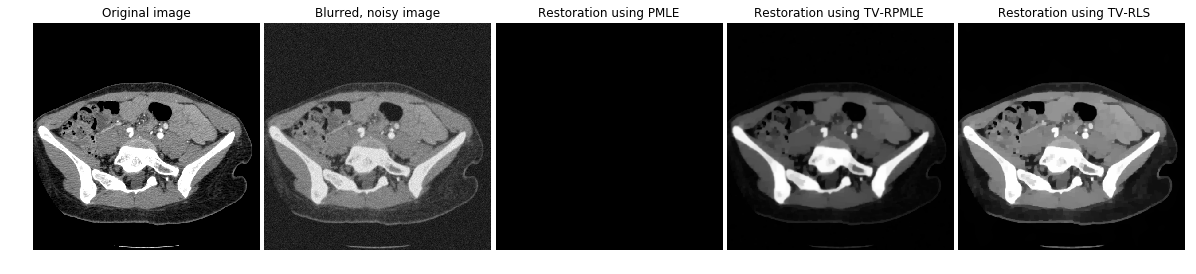

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 12))
plt.gray()

for a in (ax[0], ax[1], ax[2], ax[3],ax[4]):
       a.axis('off')
        
ax[0].imshow(data)
ax[0].set_title('Original image')

ax[1].imshow(img_noisy)
ax[1].set_title('Blurred, noisy image')

ax[2].imshow(EM_restoration)
ax[2].set_title('Restoration using PMLE')

ax[3].imshow(astPoi)
ax[3].set_title('Restoration using TV-RPMLE ')

ax[4].imshow(astL2)
ax[4].set_title(' Restoration using TV-RLS')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()


In [14]:
t=time.time()
T=deblur_TV_L2_ADMM(30/255,highpass_3x3,kernel_highpass3x3, 0.01,0.0001,30)
elapsed=time.time()-t
print(elapsed)

21.100461959838867


In [15]:
t=time.time()
K=deblur_TV_Poisson_ADMM(30/255,highpass_3x3,kernel_highpass3x3, 0.01,0.0001,30)
elapsed=time.time()-t
print(elapsed)

22.217413425445557


In [16]:
t=time.time()
EM_highpass3x3=EM(highpass_3x3,kernel_highpass3x3, 30)
elapsed=time.time()-t
print(elapsed)

0.6996791362762451


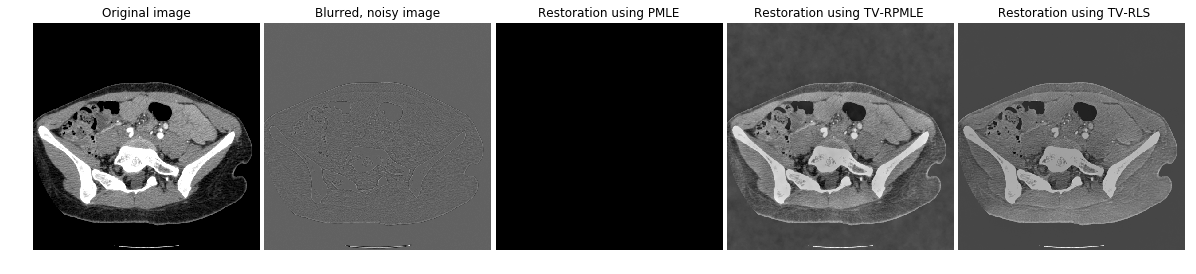

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 12))
plt.gray()

for a in (ax[0], ax[1], ax[2], ax[3],ax[4]):
       a.axis('off')
ax[0].imshow(data)
ax[0].set_title('Original image')

ax[1].imshow(highpass_3x3)
ax[1].set_title('Blurred, noisy image')

ax[2].imshow(EM_highpass3x3)
ax[2].set_title('Restoration using PMLE')

ax[3].imshow(K)
ax[3].set_title('Restoration using TV-RPMLE ')

ax[4].imshow(T)
ax[4].set_title(' Restoration using TV-RLS')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

In [18]:
t=time.time()
deblur_L2=deblur_TV_L2_ADMM(30/255,highpass_5x5,kernel_highpass5x5, 0.03,0.01,30)
elapsed=time.time()-t
print(elapsed)

21.638127088546753


In [19]:
t=time.time()
deblur_Poisson=deblur_TV_Poisson_ADMM(30/255,highpass_5x5,kernel_highpass5x5, 0.03,0.0001,30)
elapsed=time.time()-t
print(elapsed)

23.050907611846924


In [20]:
t=time.time()
EM_highpass5x5=EM(highpass_5x5,kernel_highpass5x5, 30)
elapsed=time.time()-t
print(elapsed)

1.2590529918670654


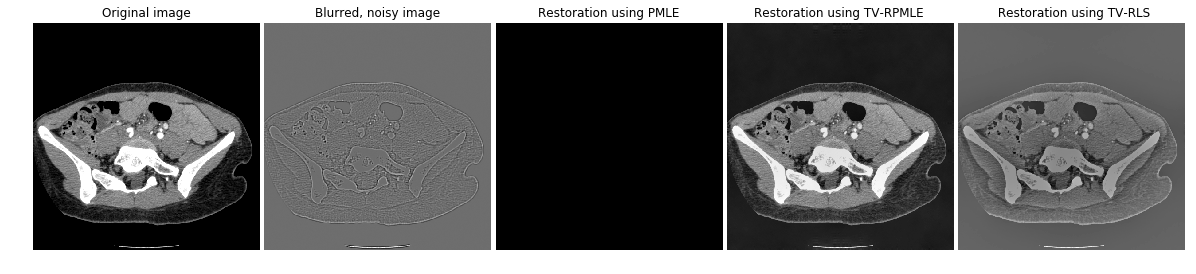

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 12))
plt.gray()

for a in (ax[0], ax[1], ax[2], ax[3], ax[4]):
       a.axis('off')

ax[0].imshow(data)
ax[0].set_title('Original image')

ax[1].imshow(highpass_5x5)
ax[1].set_title('Blurred, noisy image')

ax[2].imshow(EM_highpass5x5)
ax[2].set_title('Restoration using PMLE')

ax[3].imshow(deblur_Poisson)
ax[3].set_title('Restoration using TV-RPMLE ')

ax[4].imshow(deblur_L2)
ax[4].set_title(' Restoration using TV-RLS')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()


In [22]:
t=time.time()
L2=deblur_TV_L2_ADMM(30/255,gauss,kernel_Gaussian, 0.01,0.001,20)
elapsed=time.time()-t
print(elapsed)

19.78494119644165


In [23]:
t=time.time()
Poisson=deblur_TV_Poisson_ADMM(30/255,gauss,kernel_Gaussian, 0.05,0.01,30)
elapsed=time.time()-t
print(elapsed)

27.5517361164093


In [24]:
t=time.time()
em=EM(gauss,kernel_Gaussian,100)
elapsed=time.time()-t
print(elapsed)

17.30962085723877


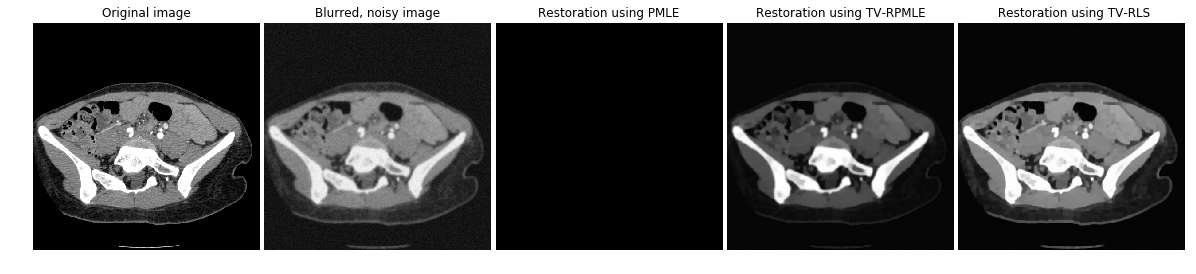

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 12))
plt.gray()

for a in (ax[0], ax[1], ax[2],ax[3],ax[4]):
       a.axis('off')

ax[0].imshow(data)
ax[0].set_title('Original image')

ax[1].imshow(gauss)
ax[1].set_title('Blurred, noisy image')

ax[2].imshow(em)
ax[2].set_title('Restoration using PMLE')


ax[3].imshow(Poisson)
ax[3].set_title('Restoration using TV-RPMLE')

ax[4].imshow(L2)
ax[4].set_title(' Restoration using TV-RLS')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()